In [28]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import time
from datetime import datetime
import numpy as np
import pandas as pd
from pandas.plotting import lag_plot
from matplotlib import pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import sklearn.linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [ ]:
'''
Follow directions here to create an API to access the data hosted on 
the drive: https://pythonhosted.org/PyDrive/quickstart.html

Once the client_secrets.json file is in ./Marin Workspace/ run the code 
below just once
'''
gauth = GoogleAuth()
gauth.LocalWebserverAuth()

In [ ]:
'''
Run the following code to download the data using the file's ID
'''
SP500_sectors_filled = '1S6lRlfRRVJT2pH_fLBgX9ZbWjroD-DSZ'
drive = GoogleDrive(gauth)
data = drive.CreateFile({'id': all_stocks_5yr})
data.GetContentFile('SP500_sectors_filled.csv')

In [3]:
sp_filled = pd.read_csv('SP500_sectors_filled.csv')

In [4]:
def remove_nulls(df):
    '''
    Takes in a dataframe and returns a mutated dataframe with rows of missing data dropped.
    '''
    
    df.dropna(inplace=True)
    
    return df

In [5]:
sp_filled.head()

,date,open,high,low,close,volume,Name,per_change,Sector
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,-0.021234,Industrials
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,-0.028878,Industrials
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL,-0.012457,Industrials
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL,0.025175,Industrials
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL,-0.063588,Industrials


In [6]:
sp_filled = remove_nulls(sp_filled)

In [7]:
sp_filled.isnull().sum()

date          0
open          0
high          0
low           0
close         0
volume        0
Name          0
per_change    0
Sector        0
dtype: int64

In [8]:
tickers_sorted = sorted(set(sp_filled['Name']))

In [9]:
df = sp_filled[['Name', 'date', 'close']]
dates_sorted = sorted(set(df.index))

In [10]:
df

,Name,date,close
0,AAL,2013-02-08,14.75
1,AAL,2013-02-11,14.46
2,AAL,2013-02-12,14.27
3,AAL,2013-02-13,14.66
4,AAL,2013-02-14,13.99
5,AAL,2013-02-15,14.50
6,AAL,2013-02-19,14.26
7,AAL,2013-02-20,13.33
8,AAL,2013-02-21,13.37
9,AAL,2013-02-22,13.57


In [11]:
df.index = [datetime.strptime(x, '%Y-%m-%d') for x in df['date'].get_values()]

In [12]:
df

,Name,date,close
2013-02-08,AAL,2013-02-08,14.75
2013-02-11,AAL,2013-02-11,14.46
2013-02-12,AAL,2013-02-12,14.27
2013-02-13,AAL,2013-02-13,14.66
2013-02-14,AAL,2013-02-14,13.99
2013-02-15,AAL,2013-02-15,14.50
2013-02-19,AAL,2013-02-19,14.26
2013-02-20,AAL,2013-02-20,13.33
2013-02-21,AAL,2013-02-21,13.37
2013-02-22,AAL,2013-02-22,13.57


In [13]:
close_df = pd.DataFrame(columns=tickers_sorted, index=dates_sorted)

In [14]:
close_df

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
close_df = df.pivot_table(('close'), ['date'], 'Name')

In [16]:
print(type(close_df.index))

<class 'pandas.core.indexes.base.Index'>


In [17]:
close_df.index = pd.to_datetime(close_df.index, format='%Y-%m-%d')

In [18]:
print(type(close_df.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [19]:
close_df

Name,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-02-08,45.08,14.75,78.90,67.8542,36.25,46.89,34.41,73.31,39.120,45.700,...,28.24,37.51,88.61,42.87,31.84,27.09,65.30,75.85,24.14,33.05
2013-02-11,44.60,14.46,78.39,68.5614,35.85,46.76,34.26,73.07,38.640,46.080,...,28.31,37.46,88.28,42.84,31.96,27.46,64.55,75.65,24.21,33.26
2013-02-12,44.62,14.27,78.60,66.8428,35.42,46.96,34.30,73.37,38.890,46.270,...,28.41,37.58,88.46,42.87,31.84,27.95,64.75,75.44,24.49,33.74
2013-02-13,44.75,14.66,78.97,66.7156,35.27,46.64,34.46,73.56,38.810,46.260,...,28.42,37.80,88.67,43.08,32.00,28.26,64.41,76.00,24.74,33.55
2013-02-14,44.58,13.99,78.84,66.6556,36.57,46.77,34.70,73.13,38.610,46.540,...,28.22,38.44,88.52,42.91,32.12,28.47,63.89,76.34,24.63,33.27
2013-02-15,42.25,14.50,79.00,65.7371,37.58,46.60,35.08,74.16,38.635,46.175,...,28.67,38.12,88.36,42.80,31.88,28.28,63.99,75.90,24.34,33.98
2013-02-19,43.01,14.26,80.72,65.7128,38.19,47.22,34.82,75.40,38.995,47.010,...,28.80,39.14,89.32,43.49,32.00,28.76,65.15,76.11,24.69,33.84
2013-02-20,42.24,13.33,79.50,64.1214,38.61,46.61,34.52,75.00,38.770,45.790,...,28.53,38.29,88.97,43.00,31.44,27.96,64.56,75.31,24.14,32.72
2013-02-21,41.63,13.37,79.06,63.7228,38.78,46.48,34.26,73.85,38.340,45.120,...,28.46,37.65,88.59,41.31,31.36,27.68,65.05,73.87,23.73,32.56


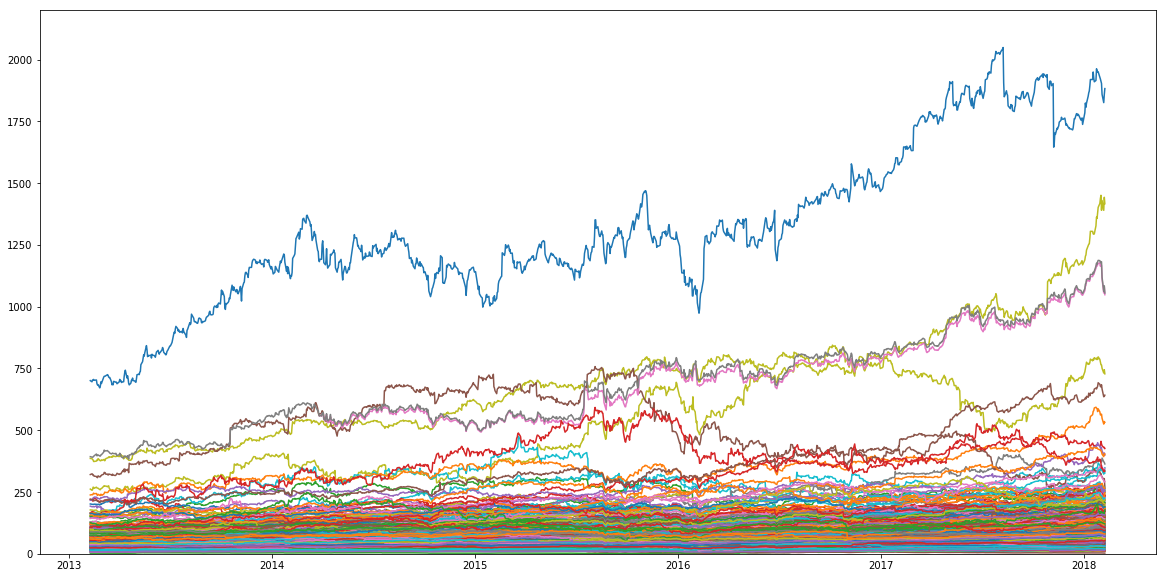

In [24]:
plt.figure(figsize=(20,10))
plt.plot(close_df)
plt.ylim([0,2200])
plt.show()

In [ ]:
close_df.isnull().sum()

In [25]:
correlation = close_df.corr()

In [26]:
correlation

Name,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
Name,,,,,,,,,,,,,,,,,,,,,
A,1.000000,0.215610,-0.494130,0.400368,0.509901,-0.203687,0.418756,0.396183,0.563067,0.528455,...,0.157963,0.713500,0.209477,0.151394,-0.286090,0.642727,-0.030249,0.235464,0.710644,0.374168
AAL,0.215610,1.000000,0.535983,0.835114,0.723115,0.773192,0.760103,0.630869,0.685319,0.693745,...,0.729636,0.553129,-0.309139,0.665504,0.008729,0.641955,0.218472,0.772007,0.519378,0.695370
AAP,-0.494130,0.535983,1.000000,0.264125,0.131630,0.701997,0.163286,0.196554,0.091777,0.105304,...,0.328782,-0.104707,-0.230396,0.469657,0.239541,0.040747,0.248917,0.499423,-0.136549,0.186245
AAPL,0.400368,0.835114,0.264125,1.000000,0.887866,0.673544,0.894304,0.848683,0.906094,0.914892,...,0.838297,0.762623,-0.525019,0.768427,-0.355464,0.831831,0.249553,0.778762,0.755852,0.928463
ABBV,0.509901,0.723115,0.131630,0.887866,1.000000,0.544060,0.921130,0.852036,0.897021,0.850391,...,0.618735,0.771599,-0.369390,0.707035,-0.312927,0.871420,0.379140,0.719369,0.748906,0.898333
ABC,-0.203687,0.773192,0.701997,0.673544,0.544060,1.000000,0.676887,0.437922,0.419611,0.449491,...,0.651374,0.189378,-0.489819,0.574617,0.125296,0.296269,0.457085,0.673967,0.179722,0.554680
ABT,0.418756,0.760103,0.163286,0.894304,0.921130,0.676887,1.000000,0.727085,0.791779,0.783781,...,0.682070,0.636699,-0.400653,0.595735,-0.176345,0.724411,0.423444,0.676768,0.655322,0.827169
ACN,0.396183,0.630869,0.196554,0.848683,0.852036,0.437922,0.727085,1.000000,0.959621,0.912542,...,0.697153,0.835099,-0.548857,0.885388,-0.627438,0.924409,0.223105,0.712794,0.772011,0.951689
ADBE,0.563067,0.685319,0.091777,0.906094,0.897021,0.419611,0.791779,0.959621,1.000000,0.946424,...,0.728890,0.907228,-0.487356,0.824993,-0.582456,0.959576,0.177472,0.719086,0.847317,0.950264


In [31]:
cm.g

ValueError: continuous-multioutput is not supported

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(correlation, cmap=cm.get_cmap('Greys'))
plt.xticks(range(len(correlation.columns)), correlation.columns)
plt.yticks(range(len(correlation.columns)), correlation.columns)

([<matplotlib.axis.YTick at 0x1a20e19a90>,
 <a list of 505 Text yticklabel objects>)

In [ ]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.cure import cure

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [ ]:
Z = linkage(close_df, 'ward')

In [ ]:
Z

In [ ]:
plt.figure(figsize=(25,10))
dendrogram(Z, leaf_rotation = 90., leaf_font_size=8.,)
plt.show()

In [ ]:
Z.shape